<a href="https://colab.research.google.com/github/dongjun-kor/Python/blob/main/IPC_Karas_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Karas를 이용한 IPC코드 2차원 시각화

In [ ]:
!pip3 install -q transformers

     |████████████████████████████████| 4.2 MB 10.4 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 66.3 MB/s 
     |████████████████████████████████| 6.6 MB 66.6 MB/s 


In [ ]:
!pip install keras-bert

  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=17435d45a1b3eb8ba4510749b87f90ab2fd6bc1d803c39e612c9a76701851a56
  Stored in directory: /root/.cache/pip/wheels/a4/e8/45/842b3a39831261aef9154b907eacbc4ac99499a99ae829b06f
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12305 sha256=f1909303dc9811aa21a750345cc461625a062647b4f349db6921169ef8c786e8
  Stored in directory: /root/.cache/pip/wheels/46/68/26/692ed21edd832833c3b0a0e21615bcacd99ca458b3f9ed571f
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3960 sha256=c38c8fcee6f695ce546c3c0456d140f1c644f472b41e0da9e4273d9926b84199
  Stored in directory: /root/.cache/pip/wheels/81/67/b5/d847588d075895281e1cf5590f819bd4cf076a554872268bd5
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=d9c32f83b9f219a4e433e56c20ccfc64ccc8912db9d5ef010d35626e

In [ ]:
import pandas as pd

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
path = 'gdrive/MyDrive/Colab Notebooks/'

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
import tensorflow as tf

import pandas as pd
import numpy as np
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

In [ ]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

In [ ]:
def copytree(src, dst, symlinks=False, ignore = None):
  for item in os.listdir(src):
    s = os.path.join(src, item)
    d = os.path.join(dst, item)
    if os.path.isdir(s):
      shutil.copytree(s, d, symlinks, ignore)
    else:
      shutil.copy2(s, d)

In [ ]:
#os.makedirs('bert')
# 존재하면 error 뜸

In [ ]:
import os
import zipfile
import shutil

# 버트 모델 다운로드
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

# colab에 bert 폴더 생성
if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

# 다운받은 버트 모형을 bert 폴더에 압축 풀기
bert_zip = zipfile.ZipFile('uncased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

# 폴더를 통째로 복사하는 함수 생성
def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

# 원래 압축이 풀린 폴더는 "bert/uncased_L-12_H-768_A-12" 이지만
 
# 분석에 편리하게 쓰기 위해 bert 폴더로 버트 모델을 이동시키자
copytree("bert/uncased_L-12_H-768_A-12", "bert")

--2022-05-15 14:54:31--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.2’

uncased_L-12_H-768_ 100%[===================>] 388.84M   116MB/s    in 3.3s    

2022-05-15 14:54:35 (119 MB/s) - ‘uncased_L-12_H-768_A-12.zip.2’ saved [407727028/407727028]



In [ ]:
#copytree(os.path.join(path, 'BERT_MODEL'), 'bert')

데이터 가져오기

In [ ]:
#train = pd.read_csv("/content/gdrive/MyDrive/sIPCcode1.csv",encoding="euc-kr") # train dataset 가져오기
#test =  pd.read_csv("gdrive/MyDrive/Colab Notebooks/Dataset/news_test.csv") # test dataset 가져오기

In [ ]:
train = pd.read_csv("/content/gdrive/MyDrive/dataset1.csv",encoding="euc-kr")
#test = pd.read_table("nsmc/"+"ratings_test.txt")

In [ ]:
train

,ID,content,info,cat
0,A01B-001/00,Hand tools (edge trimmers for lawns A01G3/06 ),0,A
1,A01B-001/02,Spades; Shovels,0,A
2,A01B-001/04,with teeth,0,A
3,A01B-001/06,Hoes; Hand cultivators,0,A
4,A01B-001/08,with a single blade,0,A
...,...,...,...,...
67354,H01B-017/64,with conductive admixtures inserts or layers,7,H
67355,H01B-017/66,"Joining insulating bodies together, e.g. by b...",7,H
67356,H01B-019/00,Apparatus or processes specially adapted for m...,7,H
67357,H01B-019/02,Drying; Impregnating,7,H


In [ ]:
SEQ_LEN = 128 # 문장 최대 길이
BATCH_SIZE = 32 # Batch size
EPOCHS = 3 # Epochs 
LR = 1e-5 # Learning Rate

pretrained_path = 'gdrive/MyDrive/Colab Notebooks/BERT_MODEL'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = 'content' # 분석할 문장의 Column
LABEL_COLUMN = 'info' # Label Column

In [ ]:
LABEL_COLUMN = 'info' # Label Column

token_dict = {}

with codecs.open(vocab_path, 'r', encoding='utf-8') as reader:
  for line in reader:
    token = line.strip()
    if "_" in token:
      token = token.replace("_","")
      token = "##" + token
    token_dict[token] = len(token_dict)

**허깅페이스에서 가져오기**

In [ ]:
token_dict

{'[PAD]': 0,
 '[unused0]': 1,
 '[unused1]': 2,
 '[unused2]': 3,
 '[unused3]': 4,
 '[unused4]': 5,
 '[unused5]': 6,
 '[unused6]': 7,
 '[unused7]': 8,
 '[unused8]': 9,
 '[unused9]': 10,
 '[unused10]': 11,
 '[unused11]': 12,
 '[unused12]': 13,
 '[unused13]': 14,
 '[unused14]': 15,
 '[unused15]': 16,
 '[unused16]': 17,
 '[unused17]': 18,
 '[unused18]': 19,
 '[unused19]': 20,
 '[unused20]': 21,
 '[unused21]': 22,
 '[unused22]': 23,
 '[unused23]': 24,
 '[unused24]': 25,
 '[unused25]': 26,
 '[unused26]': 27,
 '[unused27]': 28,
 '[unused28]': 29,
 '[unused29]': 30,
 '[unused30]': 31,
 '[unused31]': 32,
 '[unused32]': 33,
 '[unused33]': 34,
 '[unused34]': 35,
 '[unused35]': 36,
 '[unused36]': 37,
 '[unused37]': 38,
 '[unused38]': 39,
 '[unused39]': 40,
 '[unused40]': 41,
 '[unused41]': 42,
 '[unused42]': 43,
 '[unused43]': 44,
 '[unused44]': 45,
 '[unused45]': 46,
 '[unused46]': 47,
 '[unused47]': 48,
 '[unused48]': 49,
 '[unused49]': 50,
 '[unused50]': 51,
 '[unused51]': 52,
 '[unused52]': 53,

In [ ]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
    if not self._cased:
      text = text

      text = text.lower()

    spaced = ''
    for ch in text:
      if self._is_punctuation(ch) or self._is_cjk_character(ch):
        spaced += ' ' + ch + ' '
      elif self._is_space(ch):
        spaced += ' '
      elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
        continue
      else:
        spaced += ch
      tokens = []
    for word in spaced.strip().split():
      tokens += self._word_piece_tokenize(word)
    return tokens

In [ ]:
tokenizer = inherit_Tokenizer(token_dict)

In [ ]:
tokenizer.tokenize('이번에 NH투자증권 공모전 나가면 좋은 경험이 될거야.')

['[CLS]',
 '이',
 '##번',
 '##에',
 'nh',
 '##투',
 '##자',
 '##증',
 '##권',
 '공',
 '##모',
 '##전',
 '나',
 '##가',
 '##면',
 '좋',
 '##은',
 '경',
 '##험',
 '##이',
 '될',
 '##거',
 '##야',
 '.',
 '[SEP]']

In [ ]:
train['content'][16]

' for working in vineyards, orchards, or the like'

In [ ]:
tokenizer.encode(train['content'][16])

([101, 2005, 2551, 1999, 20597, 1010, 22976, 1010, 2030, 1996, 2066, 102],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
def convert_data(data_df):
  global tokenizer
  indices, targets = [], []
  for i in tqdm(range(len(data_df))):
    ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
    indices.append(ids)
    targets.append(data_df[LABEL_COLUMN][i])

  items = list(zip(indices, targets))

  indices, targets = zip(*items)
  indices = np.array(indices)
  return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
  data_df = pandas_dataframe
  data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)

  data_x, data_y = convert_data(data_df)

  return data_x, data_y

In [ ]:
train_x, train_y = load_data(train)

100%|██████████| 67359/67359 [00:12<00:00, 5470.55it/s]


In [ ]:
train_x

[array([[  101,  2192,  5906, ...,     0,     0,     0],
        [  101, 23288,  2015, ...,     0,     0,     0],
        [  101,  2007,  4091, ...,     0,     0,     0],
        ...,
        [  101, 14709,  2030, ...,     0,     0,     0],
        [  101, 17462,  1025, ...,     0,     0,     0],
        [  101, 12318,  1996, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
def sentence_convert_data(data):
  global tokenizer
  indices = []
  for i in tqdm(range(len(data))):
    print(tokenizer.tokenize(data[i]))
    ids, segments = tokenizer.encode(data[i], max_len = SEQ_LEN)
    indices.append(ids)

  items = indices
  indices = np.array(indices)
  return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences): #sentence는 list input

  data_x = sentence_convert_data(sentences)

  return data_x

In [ ]:
sentence_load_data(["오늘 날씨는 맑음", "내일 아침은 토스트를 먹을거야"])

100%|██████████| 2/2 [00:00<00:00, 4917.12it/s]

['[CLS]', '오', '##늘', '날', '##씨', '##는', '맑', '##음', '[SEP]']
['[CLS]', '내', '##일', '아', '##침', '##은', '토', '##스', '##트', '##를', '먹', '##을', '##거', '##야', '[SEP]']


[array([[101, 100, 100, 100, 100, 100, 100, 100, 102,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [101, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
         100, 102,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
# 모델정의
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training = True,
    trainable = True,
    seq_len = SEQ_LEN
)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input-Token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 Input-Segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 Embedding-Token (TokenEmbeddin  [(None, 128, 768),  23440896    ['Input-Token[0][0]']            
 g)                              (30522, 768)]                                                    
                                                                                                  
 Embedding-Segment (Embedding)  (None, 128, 768)     1536        ['Input-Segment[0][0]']      

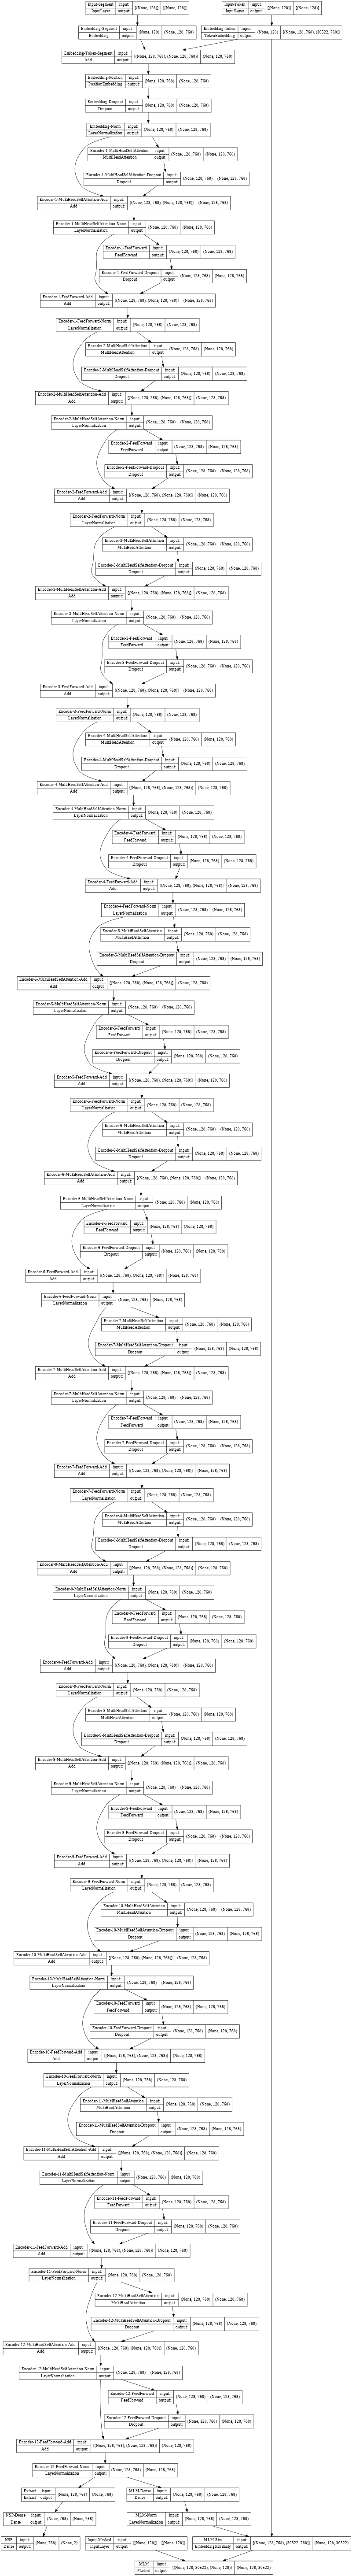

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output

  outputs = keras.layers.Dense(8, activation='softmax', kernel_initializer=tf.keras.initializers.TruncatedNormal(0.02),)(dense) #밑에 두개의 layer를 제외하고 output layer를 붙여줌

  bert_model = keras.models.Model(inputs, outputs)
  Adam = tf.keras.optimizers.Adam(lr=0.00001)
  bert_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['sparse_categorical_accuracy'])
  
  return bert_model

In [ ]:
from IPython.display import SVG

In [ ]:
from tensorflow.keras.utils import model_to_dot

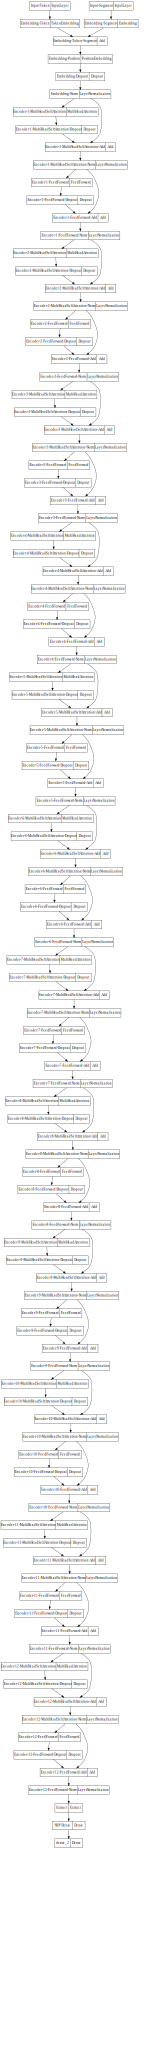

In [ ]:
SVG(model_to_dot(get_bert_finetuning_model(model), dpi = 65).create(prog='dot', format='svg'))

In [ ]:
bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs = 2, batch_size = 32, verbose = 1, shuffle=False)
bert_model.save_weights(path + "/bert1.h5")

Epoch 1/2
2105/2105 [==============================] - 1815s 852ms/step - loss: 0.1523 - sparse_categorical_accuracy: 0.9663
Epoch 2/2
2105/2105 [==============================] - 1792s 851ms/step - loss: 0.1199 - sparse_categorical_accuracy: 0.9732


In [ ]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights(path + "/bert1.h5")

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)

    return data_x

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
def get_feature_map(model):
  inputs = model.input
  outputs = model.layers[-2].output
  feature_model = Model(inputs, outputs)
  return feature_model

In [ ]:
bert_feature = get_feature_map(bert_model)

In [ ]:
labels = train['info']

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x = predict_convert_data(data_df)

    return data_x

In [ ]:
train_set = predict_load_data(train)

100%|██████████| 67359/67359 [00:12<00:00, 5222.93it/s]


In [ ]:
preds = bert_model.predict(train_set)

In [ ]:
bert_weight_list = bert_feature.predict(train_set)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [ ]:
bert_embedded = PCA(n_components=256).fit_transform(bert_weight_list)
bert_embedded = TSNE(n_components=2).fit_transform(bert_embedded)
bert_embedded

array([[-23.001339 , -27.980291 ],
       [ 22.462711 ,  35.77579  ],
       [-11.735353 ,  58.515297 ],
       ...,
       [  4.6515827, -20.855587 ],
       [-14.967542 ,  11.337859 ],
       [-21.783974 ,   5.718317 ]], dtype=float32)

In [ ]:
g=pd.DataFrame(bert_embedded)
g.to_csv("bert_embedded.csv")